In [1]:
import pathlib
import pickle
import pandas as pd
import sys
sys.path.append('./UrbRecLoop')
import model.processing_utils as processing_utils
import model.recommender as recommenders
import model.user as user
import numpy as np



In [2]:
basedir = pathlib.Path.cwd()

EXPERIMENT_HYPER_PARAMS = {'city': 'nyc', 'train': 100, 'step': 7, 'max': 196, 'topK': 20, 'alg': 'MF', 'recProb': 0.1}
exp_string = ""
for key in EXPERIMENT_HYPER_PARAMS:
    exp_string += f"{key}_{EXPERIMENT_HYPER_PARAMS[key]}__"
exp_string = exp_string[:-2]
exp_data_dir = basedir / 'data' / 'processed' / 'experiments' / exp_string
exp_data_dir


PosixPath('/Users/giovannimauro/Desktop/UrbRecLoop/data/processed/experiments/city_nyc__train_100__step_7__max_196__topK_20__alg_MF__recProb_0.1')

#### Opening auxiliary files

In [3]:
data_file = f'foursquare_complete_{EXPERIMENT_HYPER_PARAMS["city"]}_cp_small.csv'
data_version = processing_utils.extract_word(data_file)

if len(data_version) > 0:
    train_data = pd.read_csv(basedir / 'data' / 'processed' / f'city_{EXPERIMENT_HYPER_PARAMS["city"]}-{data_version}__trainWindow_{EXPERIMENT_HYPER_PARAMS["train"]}__.csv', index_col=0)
else:
    train_data = pd.read_csv(basedir / 'data' / 'processed' / f'city_{EXPERIMENT_HYPER_PARAMS["city"]}__trainWindow_{EXPERIMENT_HYPER_PARAMS["train"]}__.csv', index_col=0)
   

venue_columns = ['venueID', 'lat', 'lng', 'venue_descr', 'First_Category', 'Second_Category', 'Third_Category']
unique_venue_data = train_data[venue_columns].drop_duplicates(subset=['venueID'])

category_attribute_name = 'Second_Category'
category_to_venues = unique_venue_data.groupby(category_attribute_name)['venueID'].agg(
    list).to_dict()  




In [4]:
category_to_venues

{'Amusement Park': [3496, 24552, 21044, 27283, 27631, 30468, 30886],
 'Animal Shelter': [31060],
 'Antique Store': [1348, 11506, 33146],
 'Aquarium': [2938],
 'Arcade': [1636,
  28247,
  18755,
  15564,
  21098,
  13979,
  11830,
  16789,
  7889,
  15459],
 'Art Gallery': [21581,
  2669,
  5738,
  10351,
  7884,
  12743,
  22242,
  4482,
  2533,
  24978,
  13129,
  36215,
  15920,
  14572,
  2020,
  24486,
  8484,
  1300,
  19358,
  36113,
  3209,
  1493,
  2771,
  30359,
  34088,
  6212,
  3360,
  33714,
  25278,
  21462,
  2809,
  3362,
  2582,
  2471,
  1436,
  6609,
  10066,
  6725,
  22388,
  3363,
  33200,
  28400,
  2139,
  13508,
  7596,
  25815,
  20322,
  5125,
  34666,
  36412,
  7081,
  14890,
  33672,
  6098,
  31126,
  1894,
  20856,
  20712,
  31993,
  11585,
  16934,
  5277,
  3376,
  6293,
  35973,
  7947],
 'Arts and Crafts Store': [10274,
  7327,
  9089,
  8873,
  7562,
  3623,
  6116,
  12375,
  12151,
  8603,
  11094,
  33700,
  26745,
  28499],
 'Arts and Entertai

In [5]:
from scipy.spatial.distance import jensenshannon
from collections import Counter

def get_js_div(algorithm_recommended_list, cpop_recommended_list):
    # Step 1: Count occurrences
    count1 = Counter(algorithm_recommended_list)
    count2 = Counter(cpop_recommended_list)
    
    # Step 2: Get unique elements from both lists
    all_keys = set(count1.keys()).union(set(count2.keys()))
    
    # Step 3: Create probability distributions
    p = np.array([count1.get(k, 0) for k in all_keys], dtype=float)
    q = np.array([count2.get(k, 0) for k in all_keys], dtype=float)
    
    # Normalize to create probability distributions
    p /= p.sum()
    q /= q.sum()
    
    # Step 4: Compute JS Divergence
    js_divergence = jensenshannon(p, q)
    return js_divergence**2

In [6]:
from tqdm.notebook import tqdm


################################################################################################################################################################
collective_popularity = recommenders.CollectivePopularity()
X_train = train_data.groupby(['uid', 'venueID']).size().reset_index(name='counts')
X_train = X_train.pivot(index='uid', columns='venueID', values='counts').fillna(0)
collective_popularity.fit(X_train)
################################################################################################################################################################

user_to_js_divergence = {}
for user_recommendation_data in (exp_data_dir / 'user_recommendations').iterdir():
    userid = int(user_recommendation_data.name.split('_')[0])
    current_user = user.User(uid=userid, history=None, p=None, simulation=None)
    with open(exp_data_dir / 'user_recommendations' / f'{userid}_recommendation_list.pkl', 'rb') as f:
        recommendation_lists = pickle.load(f)
    user_history = pd.read_csv(exp_data_dir / 'user_histories' / f'{userid}_history.csv', index_col=0)
    
    cnt = 0
    user_simulated_epochs = user_history['epoch'].dropna().unique()
    user_to_js_divergence[userid] = {}


    print("######", userid, "######")
    for epoch in user_simulated_epochs:
        algorithm_recommended_list = []
        cpop_recommended_list = []
        rec_data = user_history[(user_history['epoch'] == epoch) & (user_history['simulation_state'] == 'Rec')]

        if len(rec_data.index) > 0:
            print("len(rec_data)", len(rec_data))
            print(len(recommendation_lists))
            for i in range(len(rec_data)):
                    
                past_history = user_history.copy().loc[:rec_data.index[i]-1]
                current_user.history = past_history
                
                cpop_recommendations = collective_popularity.return_topK(current_user, EXPERIMENT_HYPER_PARAMS['topK'],
                                                                        venue_category=rec_data.loc[rec_data.index[i], category_attribute_name],
                                                                        category_to_venues=category_to_venues)
                cpop_recommended_list += list(cpop_recommendations.keys())
                rec_list = recommendation_lists[cnt]
                algorithm_recommended_list += [int(elem) for elem in rec_list]
                cnt += 1  
                    
            if algorithm_recommended_list and cpop_recommended_list:
                user_to_js_divergence[userid][epoch] = get_js_div(algorithm_recommended_list, cpop_recommended_list)
            else:
                user_to_js_divergence[userid][epoch] = None
        else:
            user_to_js_divergence[userid][epoch] = None

###### 233 ######
len(rec_data) 1
3
len(rec_data) 1
3
len(rec_data) 1
3
###### 143 ######
len(rec_data) 2
5
len(rec_data) 1
5
len(rec_data) 1
5
len(rec_data) 1
5
###### 291 ######
len(rec_data) 1
2
len(rec_data) 1
2
###### 91 ######
len(rec_data) 1
1
###### 132 ######
len(rec_data) 1
2
len(rec_data) 1
2
###### 242 ######
len(rec_data) 1
1
###### 33 ######
len(rec_data) 1
1
###### 273 ######
len(rec_data) 1
4
len(rec_data) 1
4
len(rec_data) 1
4
len(rec_data) 1
4
###### 110 ######
len(rec_data) 1
1
###### 260 ######
len(rec_data) 1
3
len(rec_data) 1
3
len(rec_data) 1
3
###### 11 ######
len(rec_data) 1
1
###### 251 ######
len(rec_data) 1
1
###### 183 ######
len(rec_data) 1
2
len(rec_data) 1
2
###### 4 ######
len(rec_data) 1
3
len(rec_data) 1
3
len(rec_data) 1
3
###### 20 ######
len(rec_data) 2
2
###### 220 ######
len(rec_data) 1
2
len(rec_data) 1
2
###### 150 ######
len(rec_data) 1
6
len(rec_data) 1
6
len(rec_data) 1
6
len(rec_data) 1
6
len(rec_data) 2
6
###### 51 ######
len(rec_data) 1
3

In [7]:
with open("data/processed/experiments/city_nyc__train_100__step_7__max_84__topK_20__alg_MF__recProb_0.1/user_recommendations/180_recommendation_list.pkl", 'rb') as f:
    culo = pickle.load(f)
    print(len(culo))


3


In [8]:
culo

[{'22873': 0.00011040764219822268, '14509': -9.769845389226528e-05},
 {'22873': 0.00011040764219822268},
 {'8010': 0.058975563035274965,
  '24927': 0.04704177836074412,
  '8055': 0.044095547572588906,
  '5422': 0.03164248341348288,
  '25714': 0.031488603907567386,
  '19233': 0.029509018313088508,
  '16796': 0.029487781517637483,
  '1743': 0.029487781517637483,
  '12359': 0.023578730808413637,
  '6857': 0.020365091422994093,
  '4556': 0.019913483016435907,
  '7324': 0.019170689681396125,
  '3177': 0.016467088178024353,
  '8084': 0.015909506896777087,
  '443': 0.01553843662495517,
  '2616': 0.01477995058525393,
  '5433': 0.014759416243757812,
  '1698': 0.014756825723925315,
  '10288': 0.0147438907588189,
  '15012': 0.014743890758818741}]

In [9]:
# Initialize recommender
collective_popularity = recommenders.CollectivePopularity()
X_train = train_data.groupby(['uid', 'venueID']).size().reset_index(name='counts')
X_train = X_train.pivot(index='uid', columns='venueID', values='counts').fillna(0)
collective_popularity.fit(X_train)

epoch_divergences = {}

for user_file in (exp_data_dir / 'user_recommendations').iterdir():
    userid = int(user_file.name.split('_')[0])
    current_user = user.User(uid=userid, history=None, p=None, simulation=None)
    
    with open(exp_data_dir / 'user_recommendations' / f'{userid}_recommendation_list.pkl', 'rb') as f:
        algorithm_recs = pickle.load(f)
        
    user_history = pd.read_csv(exp_data_dir / 'user_histories' / f'{userid}_history.csv', index_col=0)
    
    for epoch in user_history['epoch'].dropna().unique():
        if epoch not in epoch_divergences:
            epoch_divergences[epoch] = {}
            
        rec_data = user_history[(user_history['epoch'] == epoch) & 
                                (user_history['simulation_state'] == 'Rec')]
        
        if len(rec_data) == 0:
            epoch_divergences[epoch][userid] = None
            continue
            
        algo_recs, cpop_recs = [], []
        rec_idx = 0
        
        for i in range(len(rec_data)):
            past_history = user_history.copy().loc[:rec_data.index[i]-1]
            current_user.history = past_history
            
            cpop_recommendations = collective_popularity.return_topK(
                current_user, 
                EXPERIMENT_HYPER_PARAMS['topK'],
                venue_category=rec_data.loc[rec_data.index[i], category_attribute_name],
                category_to_venues=category_to_venues
            )
            
            
            cpop_recs += list(cpop_recommendations.keys())
            algo_recs += [int(v) for v in algorithm_recs[rec_idx]]
            rec_idx += 1
        
        epoch_divergences[epoch][userid] = get_js_div(algo_recs, cpop_recs) if algo_recs and cpop_recs else None
        


In [10]:
epoch_divergences = {int(epoch) : {int(k): v for k, v in v.items()} for epoch, v in epoch_divergences.items()}
epoch_divergences

{0: {233: None,
  143: None,
  291: 0.0,
  91: None,
  132: None,
  242: None,
  33: None,
  273: 0.4852030263919617,
  110: None,
  260: 0.5545177444479562,
  11: None,
  251: None,
  183: None,
  4: None,
  20: 0.3985596288219686,
  150: None,
  51: None,
  282: None,
  249: None,
  139: None,
  107: None,
  238: 0.13862943611198905,
  77: None,
  176: None,
  206: 0.6931471805599452,
  46: None,
  147: None,
  78: 0.5198603854199589,
  37: None,
  187: 0.5891751034759534,
  255: None,
  125: None,
  286: None,
  154: None,
  64: None,
  215: None,
  89: None,
  19: None,
  126: None,
  3: None,
  268: None,
  118: None,
  157: None,
  227: None,
  169: None,
  56: None,
  219: 0.0,
  158: None,
  267: None,
  117: None,
  129: 0.39855962882196844,
  274: None,
  99: None,
  175: None,
  234: None,
  245: None,
  135: None,
  34: None,
  197: None,
  12: None,
  263: None,
  7: 0.3812309493079698,
  81: None,
  122: None,
  252: 0.4852030263919617,
  52: 0.6238324625039506,
  153: No

In [11]:
#per each epoch, plot the avg and stddev of the js divergence
import matplotlib.pyplot as plt
import seaborn as sns

epoch_divergences_df = pd.DataFrame(epoch_divergences).T
#sort rows by index
epoch_divergences_df = epoch_divergences_df.sort_index()


epoch_divergences_df



,233,143,291,91,132,242,33,273,110,260,...,144,201,171,195,151,28,266,63,100,256
0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.485203,NaN,0.554518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.693147,NaN,NaN,NaN,NaN,0.693147,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.554518,0.467874,NaN,NaN,NaN,NaN,0.554518,0.485203,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,0.207944,NaN,NaN,NaN,NaN,NaN,...,0.467874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


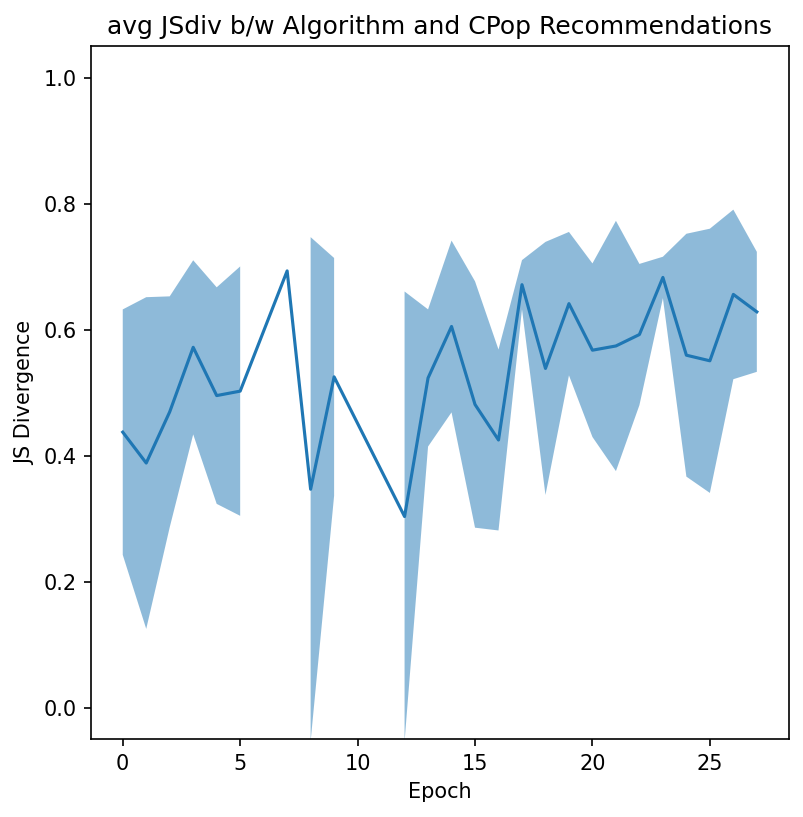

In [12]:
#plot the average js divergence per epoch
plt.figure(figsize=(6, 6), dpi = 150)
sns.lineplot(data=epoch_divergences_df.mean(axis=1))
#sqrt of std
plt.fill_between(epoch_divergences_df.index, epoch_divergences_df.mean(axis=1) - epoch_divergences_df.std(axis=1), epoch_divergences_df.mean(axis=1) + epoch_divergences_df.std(axis=1), alpha=0.5)
plt.ylim(-0.05, 1.05)
plt.title('avg JSdiv b/w Algorithm and CPop Recommendations')
plt.xlabel('Epoch')
plt.ylabel('JS Divergence')
plt.show()